**This Notebook demoes using Kera's DL toolkit pre-trained (on ImageNet) VGG16 model for movie recommendations on the MovieLens data set.**
 - Using pretrained VGG16 model (taking the output of the last layer before the first fully-connected layer: 25088 features).
 - Item recommendations on movies: given a single movie, find most similar other movies based on the cosine similarity of the movie features obtained from the deep convolutional network.
 - This is a demo only and no metrics are implemented yet, nor any comparison in performance to CF, Content-based, or hybrid recommender algorithms are done.
 - Data set with IMDB movie IDs (link.csv) is downloaded from here: https://grouplens.org/datasets/movielens/latest/ (small one containing about 9,000 movies). We then use IMDB's API to extract the poster pictures for each movie and store it locally.

**Load the pre-trained CNN model minus the fully connected layers**

In [4]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as kimage

model = VGG16(include_top=False, weights='imagenet')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

**Load the poster pictures (224, 224), score one at a time (this can be done in batch depending on the use case), save the resulting features in matrix_res 2D numpy array**

In [15]:
# path to the data directory
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
import time
import re

start_time = time.time()

data_path = '/mnt/DataSets/MovieLens/ml-latest-small'
poster_path = 'posters/'

image_size = 224
features = 25088

DIR = join(data_path, poster_path)
total_movies = len([name for name in listdir(DIR) if isfile(join(DIR, name))])
print("We have posters for", total_movies, "Movies.")

#x = [0]*total_movies
x = np.zeros(shape=(total_movies,image_size,image_size,3))
i = 0
idx_imdb_dict = {} # key:idx, val:ImdbId
imdb_idx_dict = {} # key:ImdbId, val: idx
for f in listdir(DIR):
    if isfile(join(DIR, f)):
        imdbid = re.sub('\.jpg$', '', f)
        idx_imdb_dict[i] = imdbid
        imdb_idx_dict[imdbid] = i
        image = kimage.load_img(DIR + f, target_size=(image_size, image_size))
        temp = kimage.img_to_array(image)
        temp = np.expand_dims(temp, axis=0)
        x[i] = preprocess_input(temp)
        i +=1

matrix_res = np.zeros([total_movies,features])
#for i in range(total_movies):
#    prediction = model.predict(x[i]).ravel()
#    matrix_res[i,:] = prediction
pred = model.predict(x)
matrix_res = pred.reshape((total_movies,features)).astype(np.float32)
print("Matrix shape:",matrix_res.shape)
print("--- It took %s seconds ---" % (time.time() - start_time))

We have posters for 7548 Movies.
Matrix shape: (7548, 25088)
--- It took 2135.68976020813 seconds ---


**Compute a Cosine Similarity between all Movie pairs**

In [16]:
start_time = time.time()

similarity_deep = matrix_res.dot(matrix_res.T)
norms = np.array([np.sqrt(np.diagonal(similarity_deep))])
similarity_deep = similarity_deep / (norms * norms.T) 

print("Similarity Matrix Shape", similarity_deep.shape)
print("--- It took %s seconds ---" % (time.time() - start_time))

Similarity Matrix Shape (7548, 7548)
--- It took 4.368462800979614 seconds ---


**Save the id mapping dictionaries and the Movie-Movie similarity score in a long format: (Movie1,Movie2,sim)**

In [17]:
start_time = time.time()

num_items = similarity_deep.shape[0]

sim_th = np.mean(similarity_deep) # threshold under which similarities are discarded

sim_list = []
for i in range(0,num_items-1):
    for j in range(i+1,num_items):
        if(similarity_deep[i][j] > sim_th):
            sim_list.append((idx_imdb_dict[i],idx_imdb_dict[j],similarity_deep[i][j]))                
    

#pickle.dump( save, gzip.open( data_path + "/dl_vgg16_posters.gz", "wb" ) )

print("Similarity threshold:", sim_th)
print("Number of similarities:",len(sim_list))
print("--- It took %s seconds ---" % (time.time() - start_time))

Similarity threshold: 0.109514
Number of similarities: 12422874
--- It took 19.715883255004883 seconds ---


In [9]:
# save to a gzipped csv file for inspection and later re-loading
# avoiding pickle here because I'd like to be able to read the output as well as load it anywhere

df_out = pd.DataFrame(sim_list, columns =['ItemId1','ItemId2','ImageSim'])

df_out.to_csv(data_path + "/dl_vgg16_sim_images.gz", compression="gzip", index = False)

**Show sample recommendations for a given seed Movie**

MovieIdx: [2075  996 5552 2701 6678 6105]
Scores: [ 1.          0.2819961   0.26903126  0.26373649  0.26373526  0.25934681]
IMDB MovieIds: ['114709', '351283', '481499', '389790', '432283', '361089']
Seed Movie for which we seek recommendations: 114709


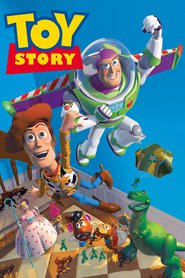

Recommendation 1 with score 0.281996 IMDB Id: 351283


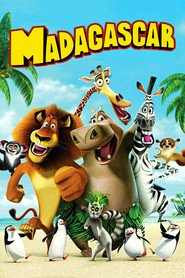

Recommendation 2 with score 0.269031 IMDB Id: 481499


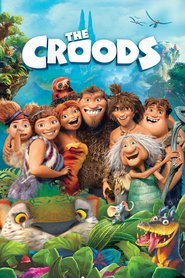

Recommendation 3 with score 0.263736 IMDB Id: 389790


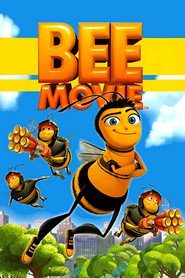

Recommendation 4 with score 0.263735 IMDB Id: 432283


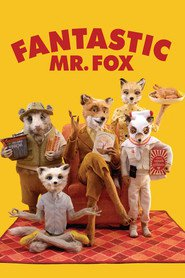

Recommendation 5 with score 0.259347 IMDB Id: 361089


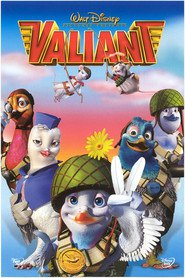

In [21]:
import requests
import json

from IPython.display import Image
from IPython.display import display
from IPython.display import HTML
from IPython.core.display import Image

#np.fill_diagonal(similarity_deep, 0)

idx = 2075 # index of a movie to display similar ones
k = 5   # number of most similar movies to display

sorted_indx = np.argsort(similarity_deep[idx,:])[::-1][:k+1]
scores = np.sort(similarity_deep[idx,:])[::-1][:k+1]
movies = [idx_imdb_dict[x] for x in sorted_indx]

print("MovieIdx:", sorted_indx)
print("Scores:", scores)
print("IMDB MovieIds:", movies)

i = 0
for movie in movies:
    if i == 0:
        print("Seed Movie for which we seek recommendations:",movies[0])
    else:
        print("Recommendation",i,"with score",scores[i], "IMDB Id:",movies[i])
    display(Image(join(DIR, movie)+".jpg"))
    i += 1 


**Evaluation**

In [46]:
df_links = pd.read_csv(os.path.join(data_path,'links.csv'), sep=',')
movie_to_imdb = {}   # key:Imdb, val:MovieId

for row in df_links.itertuples():
    if(row[2] not in movie_to_imdb):
        movie_to_imdb[row[1]] = row[2]

#imdb_idx_dict[str(movie_to_imdb[2968])]


In [53]:
k = 5   # number of most similar movies to display

# read in the seed file
df_seeds = pd.read_csv(os.path.join(data_path,'SecondToLastItemPerUser.csv'), sep=',', header = None, names=['UserId','ItemId'])
print(df_seeds.head(5))

# iterating over the dataframe rows and requesting 5 recos for each seed Item
#for i in range(simDF.shape[0]):
cnt = 0
reco_list_all = []
for row in df_seeds.itertuples(): # row[0] is the df index
    imdb_seed = movie_to_imdb[row[2]]
    try:
        idx = imdb_idx_dict[str(imdb_seed)]
    except:
        cnt += 1
        continue
    sorted_indx = np.argsort(similarity_deep[idx,:])[::-1][:k+1]
    reco_list = []
    reco_list.append(row[1])
    reco_list.append(row[2])
    for i in range(1,len(sorted_indx)):
        reco_list.append(idx_imdb_dict[sorted_indx[i]])
    reco_list_all.append(reco_list)

print("Number of movies for which posters were not found:",cnt)
df_recos = pd.DataFrame(reco_list_all, dtype='str')
df_recos.columns = ['UserId', 'Seed','Reco1', 'Reco2', 'Reco3', 'Reco4', 'Reco5'] 
df_recos.head(5)

   UserId  ItemId
0       1    2968
1       2     661
2       3   58559
3       4    3265
4       5   41569
Number of movies for which posters were not found: 142


,UserId,Seed,Reco1,Reco2,Reco3,Reco4,Reco5
0,1,2968,100758,775552,69289,108539,90985
1,2,661,396555,119567,101540,61439,72308
2,3,58559,110123,104036,100054,103253,78856
3,4,3265,990407,96098,117631,115798,87078
4,5,41569,484562,103874,90887,95652,133363


In [54]:
df_test = pd.read_csv(os.path.join(data_path,'lastItemPerUser.csv'), sep=',', header = None, names=['UserId','ItemId'])

df_eval = pd.merge(df_recos, df_test, on=['UserId'])
print(df_eval.head(5))
sum = 0
for row in df_eval.itertuples(): # row[0] is the df index
    if(row[8] in row[2:-1]):
        sum +=1
     
print("Precision:", sum/df_eval.shape[0])

  UserId   Seed   Reco1   Reco2   Reco3   Reco4   Reco5  ItemId
0      1   2968  100758  775552   69289  108539   90985    3671
1      2    661  396555  119567  101540   61439   72308     720
2      3  58559  110123  104036  100054  103253   78856   84236
3      4   3265  990407   96098  117631  115798   87078    4006
4      5  41569  484562  103874   90887   95652  133363   48385
Precision: 0.0
